In [1]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import jaccard_score
from matplotlib.colors import ListedColormap


In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

def apply_slope(y):
    from sklearn.linear_model import LinearRegression
    X = np.arange(0, len(y))
    if len(y[~np.isnan(y)]) > 3:
        ts = LinearRegression().fit(X[~np.isnan(y)].reshape(-1, 1), y[~np.isnan(y)])
        return ts.coef_
    else:
        return np.nan

In [3]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-3o4mr2uw', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-8ldi52s5', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-jjg2edzh', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-q89vplyy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-wybq_3re', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-x6jaxwjy', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39813,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:45487,Total threads: 2
Dashboard: http://127.0.0.1:44407/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:41539,


In [4]:
suffix_list = ['_rgb_tpi_ndvi_5cm', '_rgb_10cm', '_rgb_tpi_10cm', '_rgb_tpi_ndvi_10cm']
focal_area_ha = 15
cell_size = 5.0

cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [5]:
cper = gpd.read_file(cper_f)
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry.buffer(cell_size), cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))
cper_xr = cper_xr.where(cper_xr != 0)

In [6]:
df_val = pd.DataFrame(columns=['month', 'suffix', 'focal_area_ha', 'pts_thresh', 'pts_thresh_z', 'jscore'])
idx=0

In [7]:
for suffix in suffix_list:
    for month in ['july', 'sept']:
        print('----- ' + month + '------')
        print('----- ' + suffix + ' -----')
        if month == 'sept':
            shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
            da_active =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
            da_old =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()
        else:
            shps_f_list = glob.glob('./cnn_pred_results_' + month + '/burrow_pts_pred_*' + suffix + '.shp')
            if month == 'july':
                da_active =  riox.open_rasterio('./ground_data/PdogMapping_July2021/July2021_active_yrs.tif').squeeze()
                da_old =  riox.open_rasterio('./ground_data/PdogMapping_July2021/July2021_old_yrs.tif').squeeze()
        df_active = da_active.to_dataframe(name='yrs_active').drop(columns='spatial_ref')
        df_old = da_old.to_dataframe(name='yrs_old').drop(columns='spatial_ref')
        burrow_area_thresh = None

        print('...calculating burrow count')
        pts_list = []
        for i in tqdm(np.unique(cper_xr.values)):
            if np.isnan(i):
                continue
            else:
                past_row = cper[cper['OBJECTID'] == i]
                shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
                for f in shps_f_list_sub:
                    pts_tmp = gpd.read_file(f)
                    pts_tmp = pts_tmp[pts_tmp.geometry != None]
                    if burrow_area_thresh is not None:
                        pts_tmp['area'] = pts_tmp['area'].astype('int')
                        pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
                    pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                                      default_value=1, merge_alg=features.MergeAlg.add)
                    pts_list.append(pts_xr.where(pts_xr != 0))

        print('...calculating burrow density for each focal area')
        pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
                     coords=(cper_xr.y, cper_xr.x),
                     dims=('y', 'x'))
        radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi
        cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
        kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
        pts_density_xr = focal.apply(pts_all_xr,
                                            kernel, 
                                            focal._calc_sum)
        pts_density_xr = pts_density_xr / focal_area_ha

        pts_density_xr = pts_density_xr.where(da_active.notnull())

        df_pts_density = pts_density_xr.to_dataframe(name='pts_density').drop(columns='spatial_ref')

        df_out = pd.merge(
            pd.merge(
                df_active, df_old, left_index=True, right_index=True),
            df_pts_density, left_index=True, right_index=True)

        pts_density_mean = df_pts_density['pts_density'].mean()
        pts_density_std = df_pts_density['pts_density'].std()

        for pts_thresh in range(0, 51, 2):
            df_out['y_true'] = df_out['yrs_active'] > 0
            df_out['y_pred'] = df_out['pts_density'] >= pts_thresh
            jscore = jaccard_score(y_true=df_out['y_true'],
                          y_pred=df_out['y_pred'])
            pts_thresh_z = (pts_thresh - pts_density_mean)/pts_density_std
            df_val = pd.concat([df_val, pd.DataFrame({'month': month,
                                                      'suffix': suffix,
                                                      'focal_area_ha': focal_area_ha,
                                                      'pts_density': pts_thresh,
                                                      'pts_density_z': pts_thresh_z,
                                                      'jscore': jscore
                                                     }, index=[idx])])
            idx+=1

----- july------
----- _rgb_tpi_ndvi_5cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area
----- sept------
----- _rgb_tpi_ndvi_5cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area
----- july------
----- _rgb_10cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area
----- sept------
----- _rgb_10cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area
----- july------
----- _rgb_tpi_10cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area
----- sept------
----- _rgb_tpi_10cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.38it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area
----- july------
----- _rgb_tpi_ndvi_10cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.82it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area
----- sept------
----- _rgb_tpi_ndvi_10cm -----
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.27it/s]
/tmp/ipykernel_2975/960447209.py:37: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density for each focal area


In [8]:
df_val['resolution'] = df_val['suffix'].apply(lambda x: int(re.sub('cm', '', x.split('_')[-1])))
df_val['inputs'] = df_val['suffix'].apply(lambda x: ' + '.join(x.split('_')[1:-1]).upper())

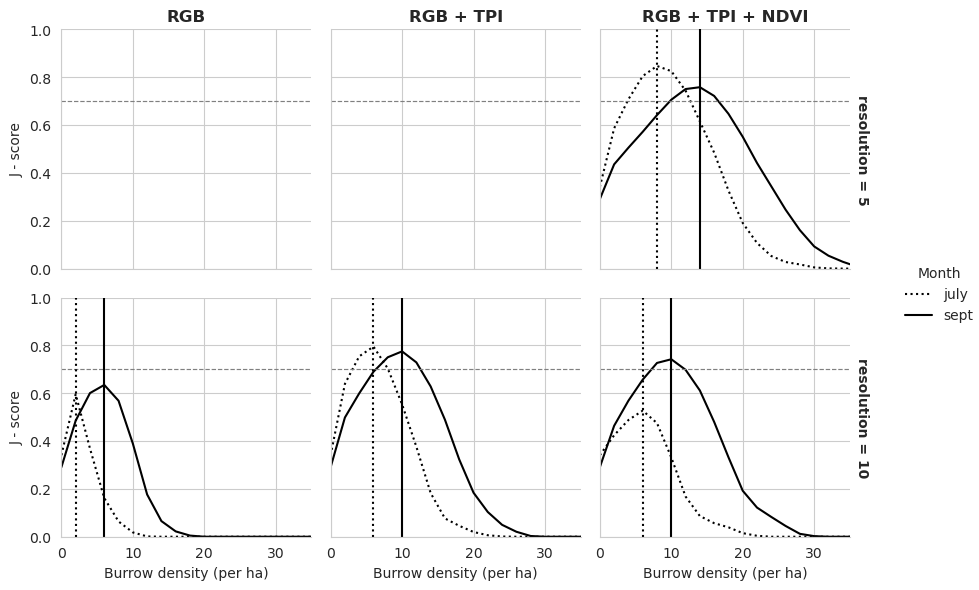

In [13]:
lss = [':', '-']
colors = ListedColormap(['black', 'black'])
sns.set_style("whitegrid")
g = sns.FacetGrid(df_val, col='inputs', row='resolution', hue='month',
                  col_order=['RGB', 'RGB + TPI', 'RGB + TPI + NDVI'],
                  palette=['black', 'black'], ylim=(0.0, 1.0), xlim=(0, 35), legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, x='pts_density', y='jscore')
g.add_legend(title='Month', borderaxespad=0)
for ax in g.axes.flatten():
    ax.set_ylabel('J - score')
    ax.set_xlabel('Burrow density (per ha)')
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')
    ax.axhline(y=0.70, linestyle='dashed', color='grey', linewidth=0.85)
    for line, ls in zip(ax.lines[:-1], lss):
        line.set_linestyle(ls)
        ax.axvline(line.get_xdata()[line.get_ydata().argmax()], linestyle=ls, color='black')
        
for margin_title in g._margin_titles_texts:
    margin_title.set_fontweight('bold')
    #margin_title.set_text(re.sub('resolution = ', '', margin_title.get_text() + ' cm'))
    

handles = g.legend.legendHandles
for handle, ls in zip(handles, lss):
    handle.set_ls(ls)

#plt.savefig('./results_figs/jscore_and_burrow_density_july_vs_sept.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

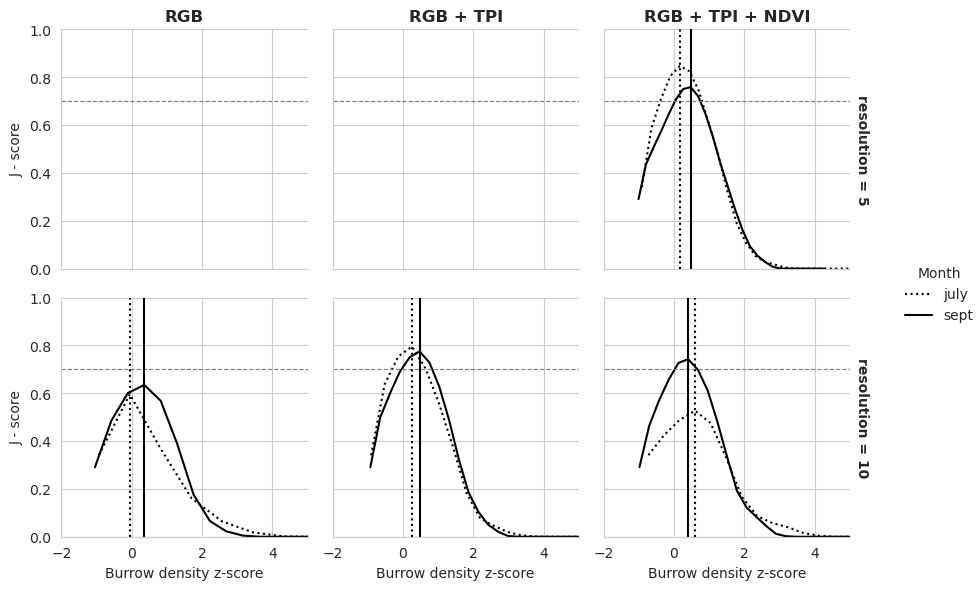

In [12]:
lss = [':', '-']
colors = ListedColormap(['black', 'black'])
sns.set_style("whitegrid")
g = sns.FacetGrid(df_val, col='inputs', row='resolution', hue='month',
                  col_order=['RGB', 'RGB + TPI', 'RGB + TPI + NDVI'],
                  palette=['black', 'black'], ylim=(0.0, 1.0), xlim=(-2.0, 5.0), legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, x='pts_density_z', y='jscore')
g.add_legend(title='Month', borderaxespad=0)
for ax in g.axes.flatten():
    ax.set_ylabel('J - score')
    ax.set_xlabel('Burrow density z-score')
    ax.set_title(re.sub('inputs = ', '', ax.get_title()), fontweight='bold')
    ax.axhline(y=0.70, linestyle='dashed', color='grey', linewidth=0.85)
    for line, ls in zip(ax.lines[:-1], lss):
        line.set_linestyle(ls)       
        ax.axvline(line.get_xdata()[line.get_ydata().argmax()], linestyle=ls, color='black')

for margin_title in g._margin_titles_texts:
    margin_title.set_fontweight('bold')
    #margin_title.set_text(re.sub('resolution = ', '', margin_title.get_text() + ' cm'))
    

handles = g.legend.legendHandles
for handle, ls in zip(handles, lss):
    handle.set_ls(ls)

#plt.savefig('./results_figs/jscore_and_burrow_density_july_vs_sept.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

In [122]:
df_val_smry = pd.DataFrame(df_val.groupby(['month', 'suffix', 'focal_area_ha']).apply(
    lambda x: x[['pts_density', 'pts_density_z']][x['jscore'] == x['jscore'].max()])).droplevel(level=3)
df_val_smry['jscore'] = df_val.groupby(['month', 'suffix', 'focal_area_ha']).apply(lambda x: x['jscore'].max())
df_val_smry = df_val_smry.reset_index()
df_val_smry['resolution'] = df_val_smry['suffix'].apply(lambda x: int(re.sub('cm', '', x.split('_')[-1])))
df_val_smry['inputs'] = df_val_smry['suffix'].apply(lambda x: ' + '.join(x.split('_')[1:-1]).upper())
#display(round(df_val_smry, 2))

In [123]:
df_val_smry

,month,suffix,focal_area_ha,pts_density,pts_density_z,jscore,resolution,inputs
0,july,_rgb_tpi_ndvi_5cm,1.0,8.0,0.162208,0.756458,5,RGB + TPI + NDVI
1,july,_rgb_tpi_ndvi_5cm,5.0,8.0,0.110685,0.814507,5,RGB + TPI + NDVI
2,july,_rgb_tpi_ndvi_5cm,10.0,8.0,0.101731,0.837150,5,RGB + TPI + NDVI
3,july,_rgb_tpi_ndvi_5cm,15.0,8.0,0.164491,0.847354,5,RGB + TPI + NDVI
4,july,_rgb_tpi_ndvi_5cm,20.0,8.0,0.148268,0.850274,5,RGB + TPI + NDVI
5,sept,_rgb_tpi_ndvi_5cm,1.0,14.0,0.438803,0.693424,5,RGB + TPI + NDVI
6,sept,_rgb_tpi_ndvi_5cm,5.0,14.0,0.384606,0.743554,5,RGB + TPI + NDVI
7,sept,_rgb_tpi_ndvi_5cm,10.0,14.0,0.380340,0.759898,5,RGB + TPI + NDVI
8,sept,_rgb_tpi_ndvi_5cm,15.0,14.0,0.470782,0.758550,5,RGB + TPI + NDVI
9,sept,_rgb_tpi_ndvi_5cm,20.0,14.0,0.452410,0.763008,5,RGB + TPI + NDVI


In [15]:
suffix = '_rgb_tpi_ndvi_5cm'
focal_area_ha = 15.0
burrow_area_thresh = None

In [136]:
pts_thresh_sept = df_val_smry['pts_density'][(df_val_smry['month']=='sept') &
                                             (df_val_smry['focal_area_ha']==focal_area_ha)].iloc[0]
z_thresh_sept = df_val_smry['pts_density_z'][(df_val_smry['month']=='sept') &
                                             (df_val_smry['focal_area_ha']==focal_area_ha)].iloc[0]
pts_thresh_july = df_val['pts_density'][(df_val['month']=='july') &
                                        (df_val['focal_area_ha']==focal_area_ha) &
                                        (df_val['pts_density_z']>=z_thresh_sept)].iloc[0]

In [137]:
pts_thresh_july

12.0

In [138]:
print('Creating July burrow density')
shps_f_list = glob.glob('./cnn_pred_results_july/burrow_pts_pred_*' + suffix + '.shp')
da_active_july =  riox.open_rasterio('./ground_data/PdogMapping_July2021/July2021_active_yrs.tif').squeeze()
da_old_july =  riox.open_rasterio('./ground_data/PdogMapping_July2021/July2021_old_yrs.tif').squeeze()

print('...calculating burrow count')
pts_list = []
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            if burrow_area_thresh is not None:
                pts_tmp['area'] = pts_tmp['area'].astype('int')
                pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list.append(pts_xr.where(pts_xr != 0))

print('...calculating burrow density at specified focal area')

pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))
radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi
cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
pts_density_xr_july = focal.apply(pts_all_xr,
                                    kernel, 
                                    focal._calc_sum)
pts_density_xr_july = pts_density_xr_july / focal_area_ha
pts_density_xr_july = pts_density_xr_july.where(da_active.notnull())

Creating July burrow density
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]
/tmp/ipykernel_2218/4112211098.py:26: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density at specified focal area


In [139]:
print('Creating September burrow density')
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*' + suffix + '.shp')
da_active_sept =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
da_old_sept =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()

print('...calculating burrow count')
pts_list = []
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            if burrow_area_thresh is not None:
                pts_tmp['area'] = pts_tmp['area'].astype('int')
                pts_tmp = pts_tmp[pts_tmp['area'] >= burrow_area_thresh]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            pts_list.append(pts_xr.where(pts_xr != 0))

print('...calculating burrow density at specified focal area')

pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))
radius_m = np.sqrt(focal_area_ha * 1e4) / np.pi
cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=radius_m)
pts_density_xr_sept = focal.apply(pts_all_xr,
                                    kernel, 
                                    focal._calc_sum)
pts_density_xr_sept = pts_density_xr_sept / focal_area_ha
pts_density_xr_sept = pts_density_xr_sept.where(da_active.notnull())

Creating September burrow density
...calculating burrow count


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.03s/it]
/tmp/ipykernel_2218/1418834282.py:26: RuntimeWarning: Mean of empty slice
  pts_all_xr = xr.DataArray(np.nanmean(pts_list, axis=0),


...calculating burrow density at specified focal area


In [140]:
pts_density_xr_diff = pts_density_xr_sept - pts_density_xr_july

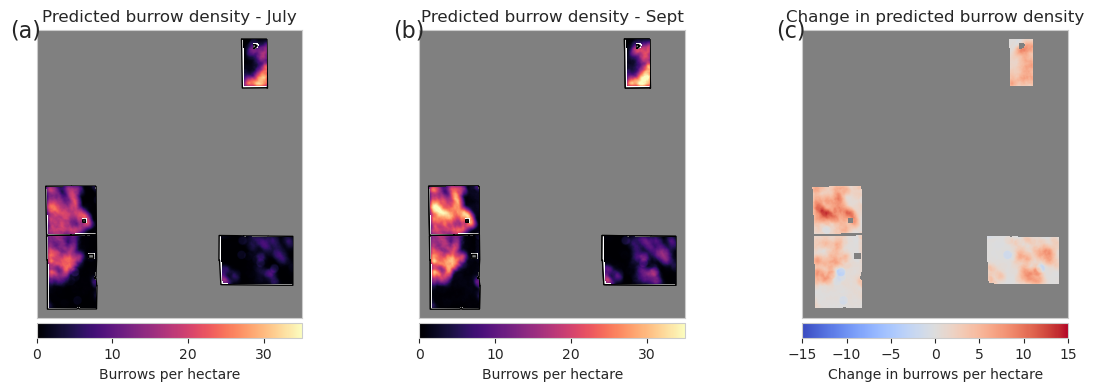

In [141]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
cmap_density = 'magma'
fig, axs = plt.subplots(ncols=3, figsize=(14, 4))
plot_buff_m = 300
cper.plot(fc='white', ec='black', ax=axs[0])
p_density_july = show(pts_density_xr_july.data, ax=axs[0], 
                      transform=pts_density_xr_july.rio.transform(), zorder=10, cmap=cmap_density, clim=(0, 35))
axs[0].set_title('Predicted burrow density - July')

cper.plot(fc='white', ec='black', ax=axs[1])
p_density_sept = show(pts_density_xr_sept.data, ax=axs[1], 
                      transform=pts_density_xr_sept.rio.transform(), zorder=10, cmap=cmap_density, clim=(0, 35))
axs[1].set_title('Predicted burrow density - Sept')

cper.plot(fc='white', ec='black', ax=axs[1])
p_density_diff = show(pts_density_xr_diff.data, ax=axs[2], 
                      transform=pts_density_xr_diff.rio.transform(), zorder=10, cmap='coolwarm', clim=(-15, 15))
axs[2].set_title('Change in predicted burrow density')

for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
    ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
    ax.set_facecolor('grey')
axs[0].annotate('(a)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)
axs[1].annotate('(b)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)
axs[2].annotate('(c)', (-0.1, 0.975), xycoords='axes fraction', fontsize=16)

# colorbar for first plot
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(p_density_july.get_images()[0],
             cax=cax1,
             orientation='horizontal', 
             label='Burrows per hectare')

# colorbar for second plot
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(p_density_sept.get_images()[0],
             cax=cax2,
             orientation='horizontal', 
             label='Burrows per hectare')

# colorbar for third plot
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('bottom', size='5%', pad=0.05)
fig.colorbar(p_density_diff.get_images()[0],
             cax=cax3,
             orientation='horizontal', 
             label='Change in burrows per hectare')
plt.show()

In [142]:
pred_col_diff = (pts_density_xr_sept >= pts_thresh_sept).astype('int') - (pts_density_xr_july >= pts_thresh_july).astype('int')
pred_col_diff = pred_col_diff.where(pred_col_diff != 0, 
                                   (pts_density_xr_sept >= pts_thresh_sept).astype('int') + 
                                    (pts_density_xr_july >= pts_thresh_july).astype('int'))
pred_col_diff = pred_col_diff.where(pred_col_diff.isin([-1, 1, 2])) * (pred_col_diff != 2).astype('int')

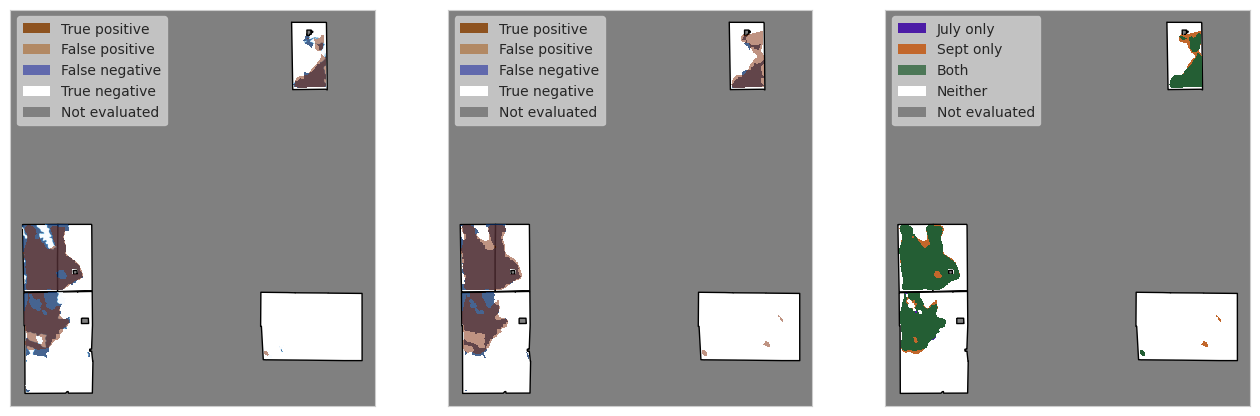

In [145]:
from matplotlib.patches import Patch
fig, axs = plt.subplots(ncols=3, figsize=(16, 6))

cper.plot(fc='white', ec='black', ax=axs[0], zorder=1)
show((da_active_sept > 0).where(da_active_july > 0).data, ax=axs[0], transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr_july >= pts_thresh_july).where(pts_density_xr_july >= pts_thresh_july).data, ax=axs[0], transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)

cper.plot(fc='white', ec='black', ax=axs[1], zorder=1)
show((da_active_sept > 0).where(da_active_sept > 0).data, ax=axs[1], transform=pts_density_xr.rio.transform(), 
     cmap='Blues', clim=(0, 1), alpha=0.75, zorder=5)
show((pts_density_xr_sept >= pts_thresh_sept).where(pts_density_xr_sept >= pts_thresh_sept).data, ax=axs[1], transform=pts_density_xr.rio.transform(),
     cmap='Oranges', clim=(0, 1), alpha=0.5, zorder=10)


cmap_change = ListedColormap(['#4c1ca6', '#245e34', '#c2672b'])
cper.plot(fc='white', ec='black', ax=axs[2], zorder=1)
show(pred_col_diff.data, ax=axs[2], transform=pts_density_xr.rio.transform(),
     cmap=cmap_change, clim=(-1, 1), zorder=10)

legend_elements = [Patch(facecolor='#854004', alpha=0.85, edgecolor='none',
                         label='True positive'),
                   Patch(facecolor='#ad7645', alpha=0.75, edgecolor='none',
                         label='False positive'),
                   Patch(facecolor='#414ba6', edgecolor='none', alpha=0.75,
                         label='False negative'),
                   Patch(facecolor='white', edgecolor='none',
                         label='True negative'),
                   Patch(facecolor='grey', edgecolor='none',
                         label='Not evaluated')]

legend_elements2 = [Patch(facecolor='#4c1ca6', edgecolor='none',
                         label='July only'),
                    Patch(facecolor='#c2672b', edgecolor='none',
                          label='Sept only'),
                    Patch(facecolor='#245e34', edgecolor='none', alpha=0.75,
                          label='Both'),
                    Patch(facecolor='white', edgecolor='none',
                          label='Neither'),
                    Patch(facecolor='grey', edgecolor='none',
                          label='Not evaluated')]
plot_buff_m = 300
for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('grey')
    ax.set_xlim((cper.total_bounds[0]-plot_buff_m, cper.total_bounds[2]+plot_buff_m))
    ax.set_ylim((cper.total_bounds[1]-plot_buff_m, cper.total_bounds[3]+plot_buff_m))
for ax in axs[:-1]:    
    ax.legend(handles=legend_elements, loc='upper left', facecolor='lightgrey')
axs[-1].legend(handles=legend_elements2, loc='upper left', facecolor='lightgrey')
plt.show()

In [43]:
axs[:-1]

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)